In [2]:
!pip install clarifai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.0/361.0 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.68.0
    Uninstalling grpcio-1.68.0:
      Succes

Enter the full path of the image to test: /content/images (3).jpeg
Outlined dress saved to: dress_outline_dress.png


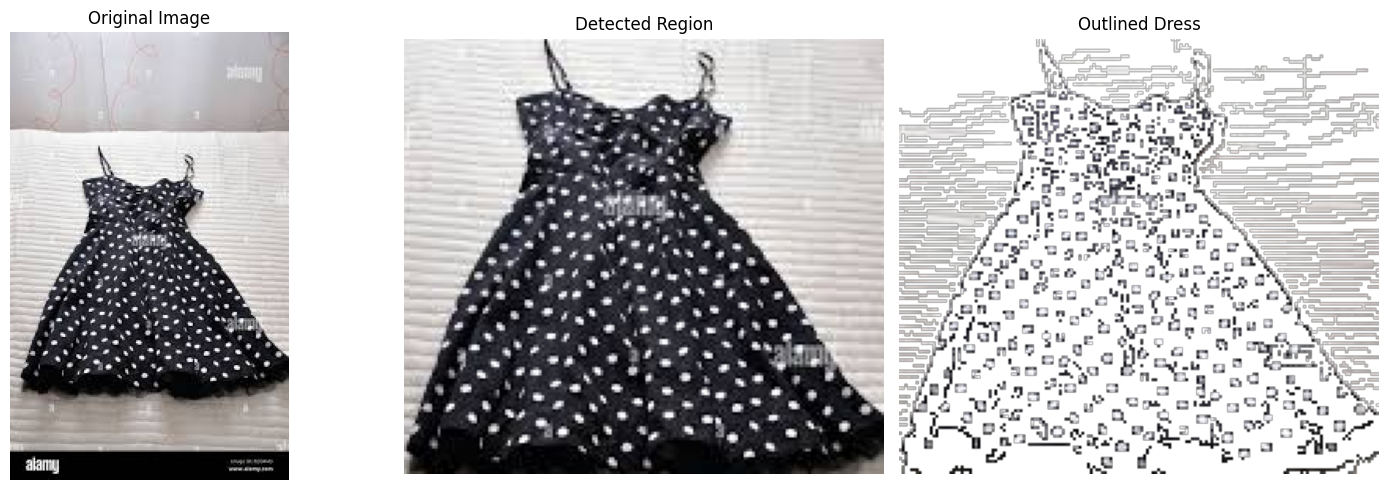

In [4]:
from clarifai.client.model import Model
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Initialize the Clarifai model with the Apparel Detection model URL
model_url = "https://clarifai.com/clarifai/main/models/apparel-detection"
detector_model = Model(
    url=model_url,
    pat="1fc718434f51433691094fcc989117ea",  # Replace with your valid PAT
)

# Get image path from the user
image_path = input("Enter the full path of the image to test: ")

# Confidence threshold for detection
CONFIDENCE_THRESHOLD = 0.5

# Check if the image exists
if not os.path.exists(image_path):
    print("The specified image does not exist! Please check the path.")
else:
    # Predict using the Clarifai model
    with open(image_path, "rb") as img_file:
        prediction_response = detector_model.predict_by_bytes(img_file.read(), input_type="image")

    # Extract predictions
    regions = prediction_response.outputs[0].data.regions
    if not regions:
        print("No clothing items detected in the image.")
    else:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        original_image = image.copy()
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for region in regions:
            top_row = region.region_info.bounding_box.top_row
            left_col = region.region_info.bounding_box.left_col
            bottom_row = region.region_info.bounding_box.bottom_row
            right_col = region.region_info.bounding_box.right_col

            # Image dimensions
            height, width, _ = image.shape

            # Bounding box coordinates
            x1, y1 = int(left_col * width), int(top_row * height)
            x2, y2 = int(right_col * width), int(bottom_row * height)

            for concept in region.data.concepts:
                name = concept.name
                confidence = round(concept.value, 4)

                if confidence >= CONFIDENCE_THRESHOLD:
                    # Crop the detected region
                    detected_region = image[y1:y2, x1:x2]

                    # Convert to grayscale and perform edge detection
                    gray = cv2.cvtColor(detected_region, cv2.COLOR_BGR2GRAY)
                    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

                    # Use edges to find contours
                    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    # Create a mask for the dress
                    mask = np.zeros_like(gray)
                    cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)

                    # Apply the mask to the original detected region
                    dress_only = cv2.bitwise_and(detected_region, detected_region, mask=mask)

                    # Convert to BGRA for transparent background
                    dress_with_alpha = cv2.cvtColor(dress_only, cv2.COLOR_BGR2BGRA)
                    dress_with_alpha[:, :, 3] = mask  # Set alpha channel based on mask

                    # Save the precise outline
                    output_path = f"dress_outline_{name}.png"
                    cv2.imwrite(output_path, dress_with_alpha)
                    print(f"Outlined dress saved to: {output_path}")

                    # Display the results
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 3, 1)
                    plt.title("Original Image")
                    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                    plt.axis("off")

                    plt.subplot(1, 3, 2)
                    plt.title("Detected Region")
                    plt.imshow(cv2.cvtColor(detected_region, cv2.COLOR_BGR2RGB))
                    plt.axis("off")

                    plt.subplot(1, 3, 3)
                    plt.title("Outlined Dress")
                    plt.imshow(cv2.cvtColor(dress_with_alpha, cv2.COLOR_BGRA2RGBA))
                    plt.axis("off")

                    plt.tight_layout()
                    plt.show()
                    break


Enter the full path of the image to test: /content/gettyimages-186543936-612x612.jpg
Detected clothing item: dress
Bounding box coordinates (pixels): Top-left (228, 72), Bottom-right (373, 384)
Clothing item 'dress' cropped and saved to: cropped_clothing_dress.png


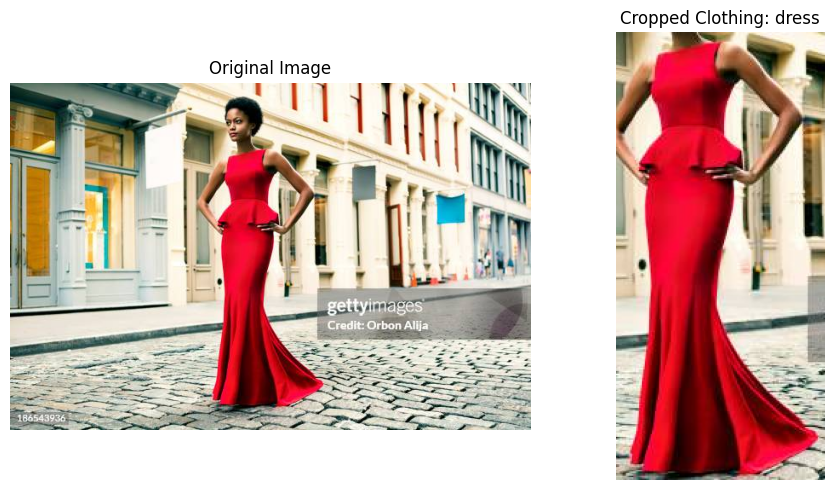

Detected clothing item: skirt
Bounding box coordinates (pixels): Top-left (230, 126), Bottom-right (371, 379)
Clothing item 'skirt' cropped and saved to: cropped_clothing_skirt.png


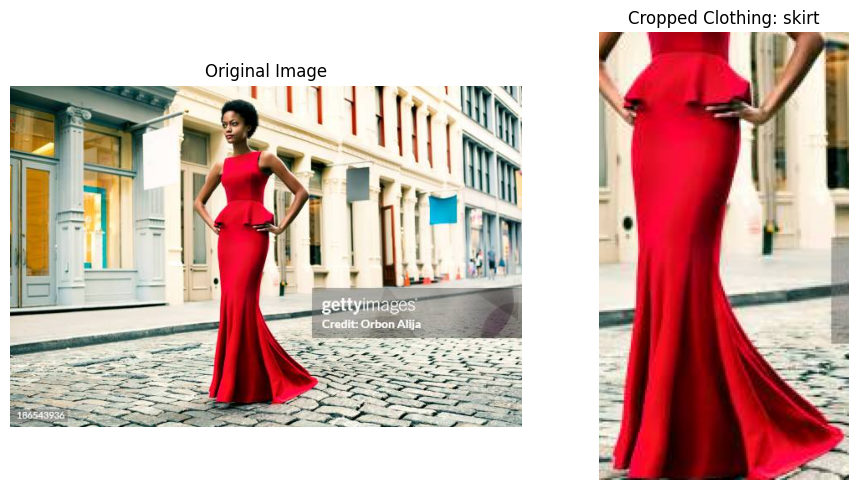

In [27]:
from clarifai.client.model import Model
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Initialize the Clarifai model with the Apparel Detection model URL
model_url = "https://clarifai.com/clarifai/main/models/apparel-detection"
detector_model = Model(
    url=model_url,
    pat="1fc718434f51433691094fcc989117ea",  # Replace with your valid PAT
)

# Get image path from the user
image_path = input("Enter the full path of the image to test: ")

# Confidence threshold for drawing bounding boxes
CONFIDENCE_THRESHOLD = 0.6  # Adjust this value as needed

# Check if the specified image exists
if not os.path.exists(image_path):
    print("The specified image does not exist! Please check the path.")
else:
    # Predict on the image using the trained model
    with open(image_path, "rb") as img_file:
        prediction_response = detector_model.predict_by_bytes(img_file.read(), input_type="image")

    # Extract predictions and draw bounding boxes
    regions = prediction_response.outputs[0].data.regions
    if not regions:
        print("No clothing items detected in the image.")
    else:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        original_image = image.copy()  # Save a copy for display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

        for region in regions:
            top_row = region.region_info.bounding_box.top_row
            left_col = region.region_info.bounding_box.left_col
            bottom_row = region.region_info.bounding_box.bottom_row
            right_col = region.region_info.bounding_box.right_col

            # Get the size of the original image
            height, width, _ = image.shape

            # Calculate bounding box coordinates in pixel values
            x1, y1 = int(left_col * width), int(top_row * height)
            x2, y2 = int(right_col * width), int(bottom_row * height)

            # Check if any concept within the region has confidence above the threshold
            for concept in region.data.concepts:
               name = concept.name
               confidence = round(concept.value, 4)

               if confidence >= CONFIDENCE_THRESHOLD:
        # Print bounding box coordinates
                    print(f"Detected clothing item: {name}")
                    print(f"Bounding box coordinates (pixels): Top-left ({x1}, {y1}), Bottom-right ({x2}, {y2})")

                    detected_region = image[y1:y2, x1:x2]

                    # Perform segmentation (GrabCut) on the detected region
                    gray = cv2.cvtColor(detected_region, cv2.COLOR_BGR2GRAY)
                    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

                    # Create an empty mask for GrabCut
                    mask = np.zeros(detected_region.shape[:2], dtype=np.uint8)
                    mask[edges > 0] = cv2.GC_FGD
                    mask[edges == 0] = cv2.GC_PR_BGD

                    # Define bounding box within the cropped region
                    bbox = (10, 10, detected_region.shape[1] - 20, detected_region.shape[0] - 20)

                    # Initialize GrabCut
                    bg_model = np.zeros((1, 65), np.float64)
                    fg_model = np.zeros((1, 65), np.float64)
                    cv2.grabCut(detected_region, mask, bbox, bg_model, fg_model, iterCount=5, mode=cv2.GC_INIT_WITH_MASK)

                    # Create a final mask and apply it to isolate the clothing
                    final_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype("uint8")
                    result_image = detected_region * final_mask[:, :, np.newaxis]

                    # Convert the result to BGRA (transparent background) for saving
                    result_with_alpha = cv2.cvtColor(result_image, cv2.COLOR_BGR2BGRA)
                    result_with_alpha[:, :, 3] = final_mask * 255

                    # Save the cropped clothing region
                    output_path = f"cropped_clothing_{name}.png"
                    cv2.imwrite(output_path, result_with_alpha)
                    print(f"Clothing item '{name}' cropped and saved to: {output_path}")

                    # Visualize the cropped clothing
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.title("Original Image")
                    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                    plt.axis("off")

                    plt.subplot(1, 2, 2)
                    plt.title(f"Cropped Clothing: {name}")
                    plt.imshow(cv2.cvtColor(result_with_alpha, cv2.COLOR_BGRA2RGBA))
                    plt.axis("off")
                    plt.tight_layout()
                    plt.show()
                    break  # Process the next detected item


Enter the full path of the image to test: /content/images (3).jpeg
Extracted dress saved to: dress_only_dress.png


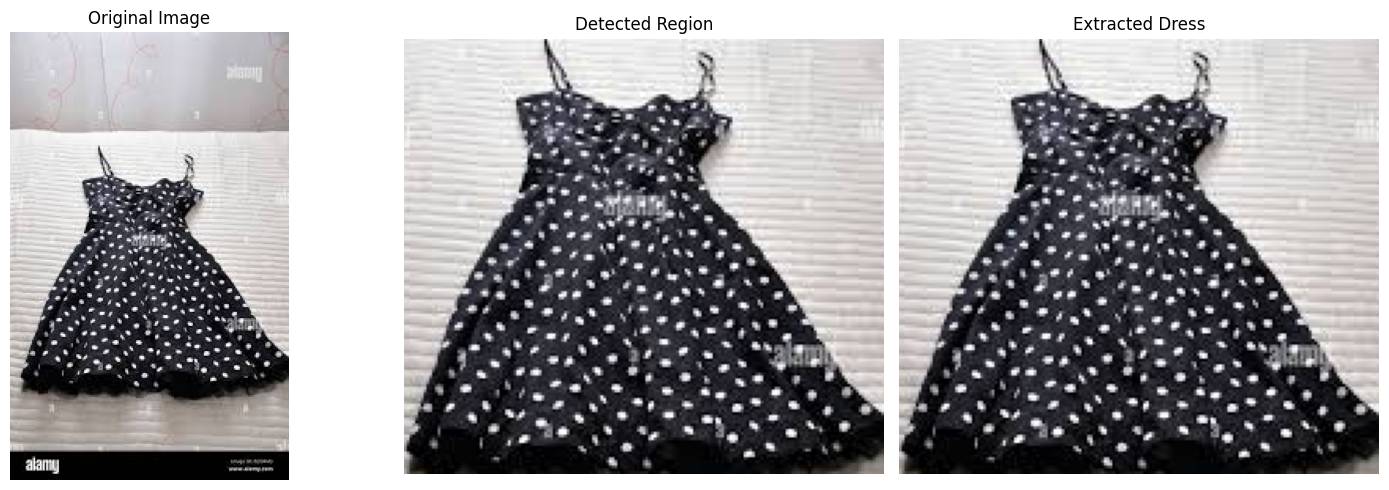

In [19]:
from clarifai.client.model import Model
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Initialize the Clarifai model with the Apparel Detection model URL
model_url = "https://clarifai.com/clarifai/main/models/apparel-detection"
detector_model = Model(
    url=model_url,
    pat="1fc718434f51433691094fcc989117ea",  # Replace with your valid PAT
)

# Get image path from the user
image_path = input("Enter the full path of the image to test: ")

# Confidence threshold for detection
CONFIDENCE_THRESHOLD = 0.5

# Check if the image exists
if not os.path.exists(image_path):
    print("The specified image does not exist! Please check the path.")
else:
    # Predict using the Clarifai model
    with open(image_path, "rb") as img_file:
        prediction_response = detector_model.predict_by_bytes(img_file.read(), input_type="image")

    # Extract predictions
    regions = prediction_response.outputs[0].data.regions
    if not regions:
        print("No clothing items detected in the image.")
    else:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        original_image = image.copy()
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for region in regions:
            top_row = region.region_info.bounding_box.top_row
            left_col = region.region_info.bounding_box.left_col
            bottom_row = region.region_info.bounding_box.bottom_row
            right_col = region.region_info.bounding_box.right_col

            # Image dimensions
            height, width, _ = image.shape

            # Bounding box coordinates
            x1, y1 = int(left_col * width), int(top_row * height)
            x2, y2 = int(right_col * width), int(bottom_row * height)

            for concept in region.data.concepts:
                name = concept.name
                confidence = round(concept.value, 4)

                if confidence >= CONFIDENCE_THRESHOLD:
                    # Crop the detected region
                    detected_region = image[y1:y2, x1:x2]

                    # Step 1: Convert to grayscale and perform initial segmentation
                    gray = cv2.cvtColor(detected_region, cv2.COLOR_BGR2GRAY)
                    edges = cv2.Canny(gray, 50, 150)

                    # Step 2: Create an initial mask
                    mask = np.zeros(detected_region.shape[:2], dtype=np.uint8)
                    mask[edges > 0] = cv2.GC_FGD  # Mark edges as sure foreground
                    mask[edges == 0] = cv2.GC_PR_BGD  # Mark other areas as probable background

                    # Step 3: Apply GrabCut for precise segmentation
                    bg_model = np.zeros((1, 65), np.float64)
                    fg_model = np.zeros((1, 65), np.float64)
                    cv2.grabCut(detected_region, mask, None, bg_model, fg_model, 5, cv2.GC_INIT_WITH_MASK)

                    # Step 4: Create a binary mask for the dress
                    dress_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')

                    # Step 5: Apply the mask to isolate the dress
                    dress_only = cv2.bitwise_and(detected_region, detected_region, mask=dress_mask)

                    # Step 6: Add transparency (alpha channel)
                    dress_with_alpha = cv2.cvtColor(dress_only, cv2.COLOR_BGR2BGRA)
                    dress_with_alpha[:, :, 3] = dress_mask  # Set alpha channel based on mask

                    # Save the result
                    output_path = f"dress_only_{name}.png"
                    cv2.imwrite(output_path, dress_with_alpha)
                    print(f"Extracted dress saved to: {output_path}")

                    # Display the results
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 3, 1)
                    plt.title("Original Image")
                    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                    plt.axis("off")

                    plt.subplot(1, 3, 2)
                    plt.title("Detected Region")
                    plt.imshow(cv2.cvtColor(detected_region, cv2.COLOR_BGR2RGB))
                    plt.axis("off")

                    plt.subplot(1, 3, 3)
                    plt.title("Extracted Dress")
                    plt.imshow(cv2.cvtColor(dress_with_alpha, cv2.COLOR_BGRA2RGBA))
                    plt.axis("off")

                    plt.tight_layout()
                    plt.show()
                    break


Enter the full path of the image to test: /content/gettyimages-186543936-612x612.jpg
Isolated dress saved to: dress_only_dress.png


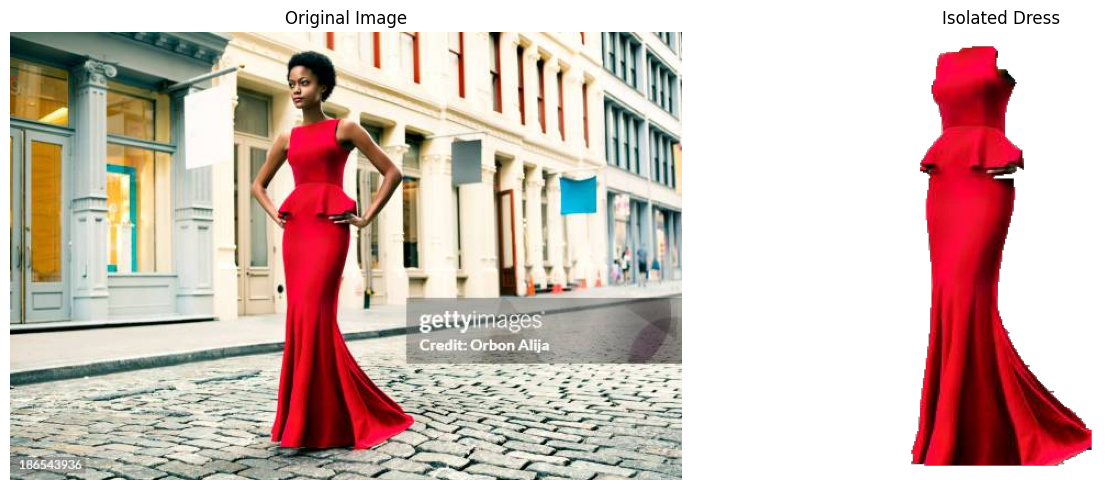

Isolated dress saved to: dress_only_skirt.png


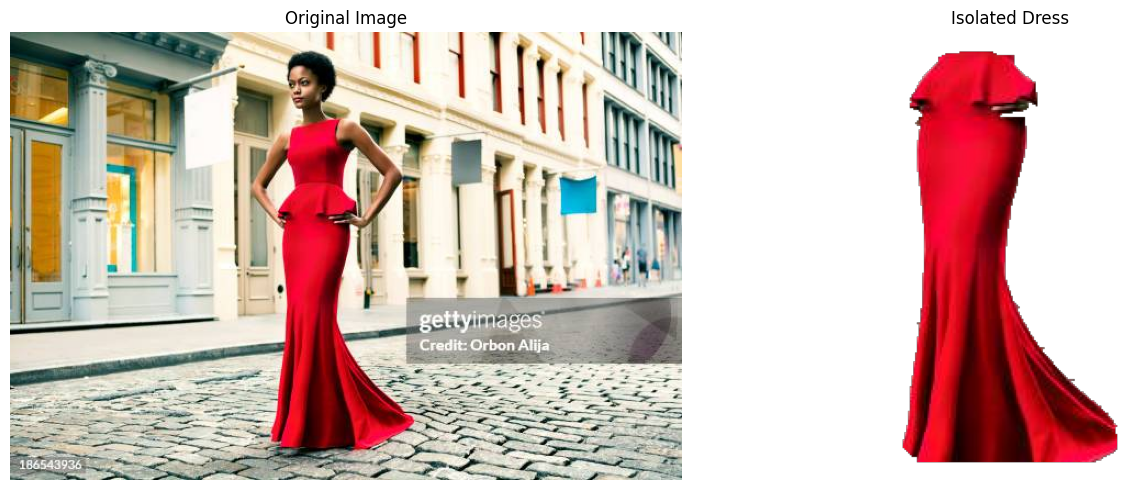

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 21>:69                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:808: error: (-215:Assertion failed) 0 <= roi.x && 0 <=
roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows in 
function 'Mat'

In [26]:
from clarifai.client.model import Model
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Initialize the Clarifai model with the Apparel Detection model URL
model_url = "https://clarifai.com/clarifai/main/models/apparel-detection"
detector_model = Model(
    url=model_url,
    pat="1fc718434f51433691094fcc989117ea",  # Replace with your valid PAT
)

# Get image path from the user
image_path = input("Enter the full path of the image to test: ")

# Confidence threshold for detection
CONFIDENCE_THRESHOLD = 0.5

# Check if the image exists
if not os.path.exists(image_path):
    print("The specified image does not exist! Please check the path.")
else:
    # Predict using the Clarifai model
    with open(image_path, "rb") as img_file:
        prediction_response = detector_model.predict_by_bytes(img_file.read(), input_type="image")

    # Extract predictions
    regions = prediction_response.outputs[0].data.regions
    if not regions:
        print("No clothing items detected in the image.")
    else:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        original_image = image.copy()

        for region in regions:
            top_row = region.region_info.bounding_box.top_row
            left_col = region.region_info.bounding_box.left_col
            bottom_row = region.region_info.bounding_box.bottom_row
            right_col = region.region_info.bounding_box.right_col

            # Image dimensions
            height, width, _ = image.shape

            # Bounding box coordinates
            x1, y1 = int(left_col * width), int(top_row * height)
            x2, y2 = int(right_col * width), int(bottom_row * height)

            for concept in region.data.concepts:
                name = concept.name
                confidence = round(concept.value, 4)

                if confidence >= CONFIDENCE_THRESHOLD:
                    # Step 1: Crop the detected region
                    detected_region = image[y1:y2, x1:x2]

                    # Step 2: Create a mask for GrabCut
                    mask = np.zeros(detected_region.shape[:2], dtype=np.uint8)

                    # Initialize GrabCut models
                    bg_model = np.zeros((1, 65), np.float64)
                    fg_model = np.zeros((1, 65), np.float64)

                    # Bounding box for GrabCut (relative to cropped region)
                    grabcut_rect = (10, 10, detected_region.shape[1] - 20, detected_region.shape[0] - 20)

                    # Apply GrabCut
                    cv2.grabCut(
                        detected_region,
                        mask,
                        grabcut_rect,
                        bg_model,
                        fg_model,
                        iterCount=5,
                        mode=cv2.GC_INIT_WITH_RECT,
                    )

                    # Refine the mask: 1 and 3 are foreground
                    refined_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")

                    # Step 3: Isolate the dress
                    dress_only = detected_region * refined_mask[:, :, np.newaxis]

                    # Convert to transparent background
                    dress_with_alpha = cv2.cvtColor(dress_only, cv2.COLOR_BGR2BGRA)
                    dress_with_alpha[:, :, 3] = refined_mask * 255  # Alpha channel

                    # Save the dress
                    output_path = f"dress_only_{name}.png"
                    cv2.imwrite(output_path, dress_with_alpha)
                    print(f"Isolated dress saved to: {output_path}")

                    # Display the results
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 2, 1)
                    plt.title("Original Image")
                    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                    plt.axis("off")

                    plt.subplot(1, 2, 2)
                    plt.title("Isolated Dress")
                    plt.imshow(cv2.cvtColor(dress_with_alpha, cv2.COLOR_BGRA2RGBA))
                    plt.axis("off")

                    plt.tight_layout()
                    plt.show()
                    break
